Dataset by @Krista.Mar

In [90]:
import pandas as pd
import numpy as np
import re
import glob
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
%matplotlib inline

### Notes:
* What if you only grabbed stuff that had more retweets / favorites?

75

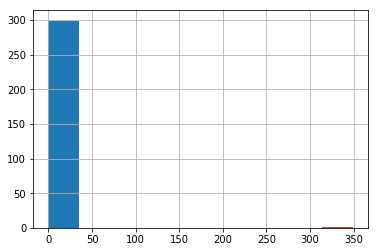

In [93]:
pd.read_csv("/Users/jasonxie/Downloads/data/data_Houston/2017-09-11.csv", delimiter=";")["favorites"].hist()
np.sum(pd.read_csv("/Users/jasonxie/Downloads/data/data_Houston/2017-09-11.csv", delimiter=";")["favorites"] > 0)

In [118]:
pattern = "http"

In [248]:
dirs = glob.glob("/Users/jasonxie/Downloads/data/data_Houston/*.csv")
sentences = []
for dir_ in dirs:
    try:
        df = pd.read_csv(dir_, delimiter=";")
#         df = df[~df.text.str.contains(pattern)]
        new_sentences = list(df['text'].values)
        for sentence in new_sentences:
#             regex = re.compile('[^a-zA-Z]')
#             sentence = regex.sub(sentence, regex)
            sentence = re.sub(r'^https?:\/\/.*[\r\n]*', '', sentence, flags=re.MULTILINE)
            sentence = re.sub(" \d+", '', sentence)
            sentence = re.sub(r'\w*\d\w*', '', sentence)
        
            sentences.append(sentence)
    except Exception as e:
        print e

expected string or buffer
Error tokenizing data. C error: Expected 10 fields in line 70, saw 11

expected string or buffer
expected string or buffer
expected string or buffer
expected string or buffer
expected string or buffer
expected string or buffer
expected string or buffer
Error tokenizing data. C error: Expected 10 fields in line 489, saw 11

expected string or buffer
expected string or buffer
expected string or buffer
expected string or buffer
expected string or buffer


In [249]:
print len(sentences)

13760


In [250]:
sentences[:20]

[' D, Houston, TX, $, beds,. baths http:// bubly.us/ZRdB',
 'Accident cleared in #WestSide on I- katy Fwy Outbound after Bingle Rd, stop and go traffic back to Wirt, delay of mins #traffic',
 "In the beginning I thought I was doing something now I'm straight beast mode for now @Northeast\xe2\x80\xa6 https://www. instagram.com/p//",
 'Woman killed after striking-wheeler in Humble http:// bubly.us/ZRfW',
 ' Bosphorus St, Houston, TX, $, beds, baths http:// bubly.us/ZRcq',
 'Just posted a photo @Meyerland, Houston https://www. instagram.com/p/BXRTySMFRQP/',
 ' Touchstone St, Houston, TX, $, beds, bath http:// bubly.us/ZRfR',
 "'Young Sheldon' is a genius, but Jim... http:// bubly.us/ZRfQ",
 "Gotta try Torchy's Tacos for #tacotuesday #roadlife #Houston #TexMex @Torchy's Tacos https://www. instagram.com/p//",
 'Catch Me Live At @ To Bless The Stage For The Homie  Behind The\xe2\x80\xa6 https://www. instagram.com/p//',
 ' Avalon Pl, Houston, TX, $, beds,. baths http:// bubly.us/ZRfI',
 ' Cle

In [252]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.5, min_df=10,
                                   max_features=10**5,
                                   stop_words='english',
                                   strip_accents="ascii"
                                  )
tfidf = tfidf_vectorizer.fit_transform(sentences)

In [253]:
tfidf_vectorizer.vocabulary_.keys()[:10]

[u'prices',
 u'hanging',
 u'hermann',
 u'bringing',
 u'probiotic',
 u'wednesday',
 u'cooking',
 u'kids',
 u'controversy',
 u'music']

In [254]:
print tfidf.shape

(13760, 1562)


### get rid of dups

In [255]:
tfidf = tfidf.todense()
tfidf = np.unique(tfidf, axis=0)

In [256]:
print tfidf.shape
from scipy import sparse
tfidf = sparse.csr_matrix(tfidf)

(10336, 1562)


In [257]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [258]:
n_components = 10
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words=20)

Topic #0: traffic stop fwy accident delay mins right bit ly downtown cleared westside outbound lp lanes left sam water blocks hwy
Topic #1: houston texas city family htown god way real town ward north museum hot ya university heart southeast arts south pray
Topic #2: http bubly tx beds baths pearland st pasadena dr school place oak ln son bath district green ct porte crowd
Topic #3: beer untp drinking http photo better white world light ipa art summer ve heights style brewing pretty byb color super
Topic #4: swarmapp tx houston bar center food house dinner favorite restaurant club lunch george grill airport time kitchen pizza sugar pic
Topic #5: twitter like don home pic know got new make life tour love check say look want did looking lol getting
Topic #6: just posted photo video fitness stadium galleria la studio casa lounge nrg shop girl southwest store eat village rice stolt
Topic #7: day today tonight time come night happy love great ready week new thanks tomorrow live friday storm

## eyeballing topics
* 0 traffic
* 1 stuff about the city
* 4 food
* 6 teenagers
* 7 time and weather
* 9 disaster stuff

In [263]:
topic_distributions = nmf.fit_transform(tfidf)

In [264]:
topic_distributions.shape

(10336, 10)

In [266]:
for i in range(n_components):
    top_indices = np.argsort(topic_distributions[:,i])[-20:]
    sentences = tfidf_vectorizer.inverse_transform(tfidf[top_indices])
    print "==== for topic %d ====" % i
    for sentence in sentences:
        print " ".join(sentence)
    print "\n\n"

==== for topic 0 ====
wb stop shoulder sam right pkwy northside ly lanes http houston ella blvd blocks bit accident
westside westpark wb traffic tollway stop st rd mins left lane fondren delay blocked accident
traffic swside sw stop stall right outbound mins lp lane kirby fwy dr delay blocks
traffic sw stopped sb right rd old mins lp lane katy fwy delay blocked accident
traffic sam right pkwy nb ly lane http houston fwy emergency eastside crews block bit baytown
traffic sb sam pkwy ly left lane http houston fwy emergency eastside crews block bit baytown
wb water traffic toll rd ly lanes hwy http high harris hardy frontage bit beltway affecting
traffic tollway toll stop stall sam plz nb mins left lane houston forest delay briar blocks
tomball tollway stop sam pkwy outbound northside ly left lane hwy http houston blocks bit accident
york westside traffic tollway toll stop sam plz nb mins little hwy houston delay cleared accident
wb vehicle traffic tollway telephone stop southside sam rig